In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import sys
from progressbar import progressbar

In [2]:
0.000664239512*0.6022*1e6

400.00503412639995

# Plot the heatmap of occupancy comparison

In [2]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num

In [80]:
# Generate parameters
# input units: M
# output units: nm & s
# conversion: 0.6022 nm^-3 = 1 M

def __staticParms(hasTargets = True):
    
    kaPN = lambda K: np.round(200,10)
    kbPN = lambda K: np.round(kaPN(K)/K,10)
    
    kaPS = lambda K: np.round(1000,10)
    kbPS = lambda K: np.round(kaPS(K)/K,10)
    
    kbPP = lambda K: np.round(10 / (K*C0/1e1)**(4/9), 10)
    kaPP = lambda K: np.round(K*kbPP(K), 10)
    
    V0 = 2.1e4 # nm^3
    VtoL = 1000 # nm^2

    if hasTargets:
        CN0 = 10/V0 # nm^-3
        CS0 = 2/V0
    else:
        CN0 = 12/V0 # nm^-3
        CS0 = 20/V0
    C0 = 0.6022 # 0.6022 nm^-3 = 1 M 
    
    return kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0
    
def GenParameters(
    filename='', ifwrite=False, hasTargets = True,
    KPS=lambda KPN: 1e3*KPN, 
    CP0=[np.nan], NP0=[np.nan], 
    KPN=[np.nan], KPP=[np.nan], 
    area3Dto1D=[np.nan],
):
    headers = [
        "ID", "CN0", "CS0", "CP0", 
        "KPS", "KPN", "KPP", "gamma", 
        "kaPS", "kaPN", "kaPP", 
        "kbPS", "kbPN", "kbPP"
    ]

    # generate data
    data = []
    number = 0
    kaPP, kbPP, kaPN, kbPN, kaPS, kbPS, V0, VtoL, CN0, CS0, C0 = \
    __staticParms(hasTargets)

    # These parameters are fixed
    if np.isnan(CP0).any() & np.isnan(NP0).any():
        raise ValueError('No protein provided! Set CP0 or NP0!')
    elif not np.isnan(CP0).any():
        CP0_list = np.array(CP0)*C0 # convert M to nm^-3
    else:
        CP0_list = np.array(NP0) / V0
        
    if np.isnan(KPN).any():
        raise ValueError('No KPN provided!')
    else:
        KPN_list = np.array(KPN)/C0
        
    if np.isnan(KPP).any():
        raise ValueError('No KPP provided!')
    else:
        KPP_list = np.array(KPP)/C0
        
    if np.isnan(area3Dto1D).any():
        raise ValueError('No area3Dto1D provided!')
    else:
        area3Dto1D_list = np.array(area3Dto1D)
    
    for _CP0 in CP0_list:
        # These parameters are varied
        for _KPN in KPN_list:
            _KPS = KPS(_KPN*C0)/C0
            for _area3Dto1D in area3Dto1D_list:
                for _KPP in KPP_list:
                    entry = {
                        'ID':number,
                        "CN0":CN0,
                        "CS0":CS0,
                        "CP0":_CP0,
                        "KPN":np.round(_KPN, 10),
                        "kaPN":kaPN(_KPN),
                        "kbPN":kbPN(_KPN),
                        "KPS":np.round(_KPS, 10),
                        "kaPS":kaPS(_KPS),
                        "kbPS":kbPS(_KPS),
                        "KPP":np.round(_KPP, 10),
                        "kaPP":kaPP(_KPP),
                        "kbPP":kbPP(_KPP),
                        "gamma":VtoL/_area3Dto1D
                    }
                    data.append(entry)
                    number += 1

    if ifwrite:
        # Specify the output CSV file name
        output_file = filename
        # # Write the data to the CSV file
        import csv
        with open(output_file, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=headers)
            writer.writeheader()
            writer.writerows(data)
        print("CSV file generated successfully!")
    
    return pd.DataFrame(data, columns=headers)


In [38]:
parm_Nonly = GenParameters(
    hasTargets=False, KPN = 2*np.logspace(1,3,3+2*100),
    NP0 = [1], area3Dto1D = [100], KPP = np.logspace(1,10,10+9*20),
)
parm_Target = GenParameters(
    hasTargets=True, KPN = 2*np.logspace(1,3,3+2*100),
    NP0 = [1], area3Dto1D = [100], KPP = np.logspace(1,10,10+9*20),
)
if parm_Nonly.shape[0] == parm_Target.shape[0]:
    print('Size of parameter sets validated!', parm_Target.shape[0])
else:
    raise ValueError('Parameter sets have different sizes!')

Size of parameter sets validated! 38570


In [93]:
nSize = parm_Nonly.shape[0]
pBound_Nonly = np.zeros(nSize)
pBound_singleS = np.zeros(nSize)
pBound_doubleS = np.zeros(nSize)
resT_Nonly = np.zeros(nSize)
resT_singleS = np.zeros(nSize)
resT_doubleS = np.zeros(nSize)
for i in progressbar(range(nSize)):
    pBound_Nonly[i] = ana.ana_bound_ratio(parm_Nonly.iloc[i], numClusterS=0)
    pBound_singleS[i] = ana.ana_bound_ratio(parm_Target.iloc[i], numClusterS=1)
    pBound_doubleS[i] = ana.ana_bound_ratio(parm_Target.iloc[i], numClusterS=2)
    resT_Nonly[i] = ana.ana_resTime_balance(parm_Nonly.iloc[i], numClusterS=0)
    resT_singleS[i] = ana.ana_resTime_balance(parm_Target.iloc[i], numClusterS=1)
    resT_doubleS[i] = ana.ana_resTime_balance(parm_Target.iloc[i], numClusterS=2)

100% (38570 of 38570) |##################| Elapsed Time: 0:00:51 Time:  0:00:51


In [94]:
C0 = 0.6022
df = {
    'logKPN':np.log10(parm_Nonly['KPN']),  
    'logKPP':np.log10(parm_Nonly['KPP']*C0),
    'pBoundA':pBound_Nonly,
    'pBoundB':pBound_singleS,
    'pBoundC':pBound_doubleS,
    'tauA':resT_Nonly,
    'tauB':resT_singleS,
    'tauC':resT_doubleS,
}
df = pd.DataFrame(df)
pivot_pBoundA = df.pivot(index="logKPN", columns="logKPP", values="pBoundA")
pivot_pBoundB = df.pivot(index="logKPN", columns="logKPP", values="pBoundB")
pivot_pBoundC = df.pivot(index="logKPN", columns="logKPP", values="pBoundC")
pivot_tauA = df.pivot(index="logKPN", columns="logKPP", values="tauA")
pivot_tauB = df.pivot(index="logKPN", columns="logKPP", values="tauB")
pivot_tauC = df.pivot(index="logKPN", columns="logKPP", values="tauC")

In [103]:
def set_heatmap_parameters(
    ax, cbarLabelSize=20, tickFontSize=22, xtickRot=30,
    cbarAxTickKws = {'width':1, 'length':10, 'color':'gray'},
    heatmapAxTickKws = {'width':1, 'length':10, 'color':'gray'},
    highlights = ([40, 40, 160],[0, 160, 160]),
):
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=cbarLabelSize)

    ax.set_yticks(
        ax.get_yticks(), 
        ['$10^{%.1f}$'%float(text.get_text()) for text in ax.get_yticklabels()], 
        fontsize=tickFontSize, rotation=0,
    )

    ax.set_xticks(
        ax.get_xticks(), 
        ['$10^{%.1f}$'%(float(text.get_text())) for text in ax.get_xticklabels()], 
        fontsize=tickFontSize, rotation=xtickRot,
    )

    # Customize tick width
    ax.tick_params(axis='both', **heatmapAxTickKws)
    cbar.ax.tick_params(axis='both', **cbarAxTickKws)

    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.scatter(highlights[0], highlights[1], 150, color='tab:olive')

In [118]:
np.unique(parm_Nonly['KPP'])[40], np.unique(parm_Nonly['KPN'])[0], np.unique(parm_Nonly['KPS'])[0]

(1333.5863868136, 33.2115576221, 33211.5576220525)

In [119]:
np.unique(parm_Nonly['KPP'])[40], np.unique(parm_Nonly['KPN'])[160], np.unique(parm_Nonly['KPS'])[160]

(1333.5863868136, 1274.8164542088, 1274816.4542088378)

In [120]:
np.unique(parm_Nonly['KPP'])[160], np.unique(parm_Nonly['KPN'])[160], np.unique(parm_Nonly['KPS'])[160]

(690727692.3068488, 1274.8164542088, 1274816.4542088378)

## protein bound ratios

##### $\theta_B-\theta_A$

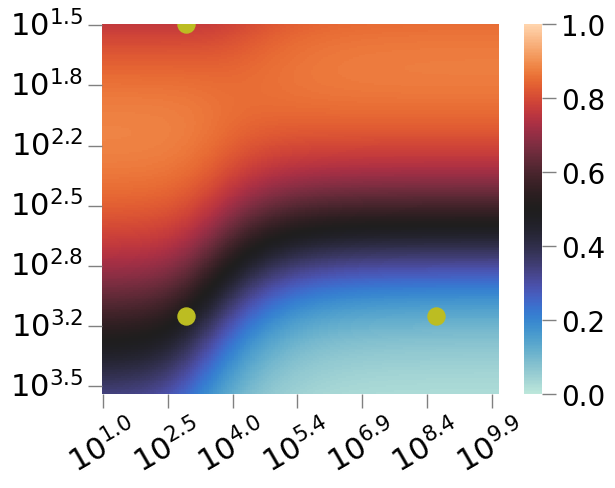

In [109]:
ax = sns.heatmap(
    pivot_pBoundB-pivot_pBoundA,
    vmin=0, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax)
plt.show()

##### $\theta_C-\theta_B$

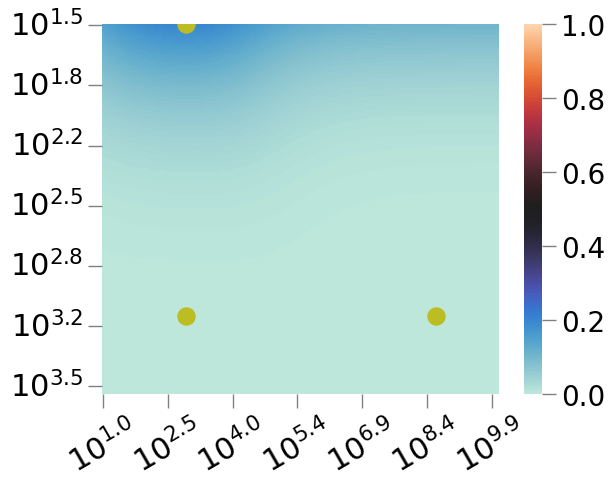

In [110]:
ax = sns.heatmap(
    pivot_pBoundC-pivot_pBoundB,
    vmin=0, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax)
plt.show()

##### $\theta_C-\theta_A$

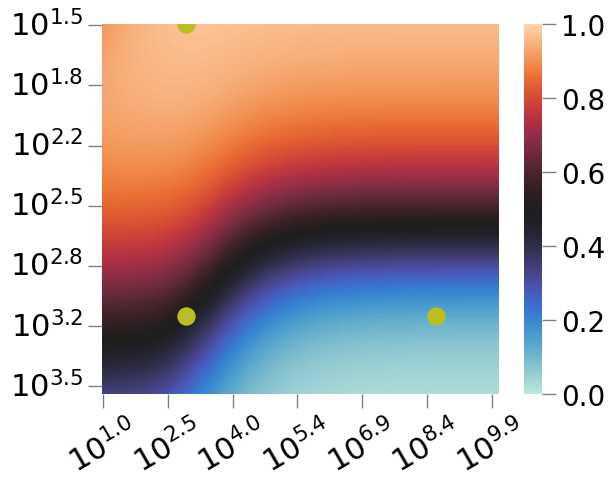

In [111]:
ax = sns.heatmap(
    pivot_pBoundC-pivot_pBoundA,
    vmin=0, vmax=1, cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax)

plt.show()

## residence times

##### $\tau_B/\tau_A$

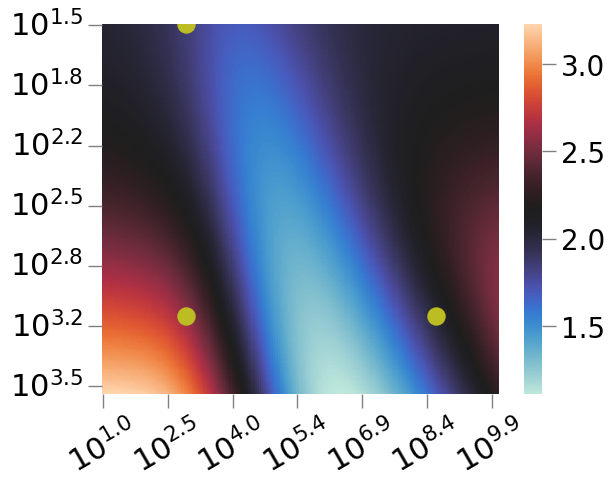

In [104]:
ax = sns.heatmap(
    np.log10(pivot_tauB/pivot_tauA),
#     pivot_tauB/pivot_tauA,
#     vmin=0, vmax=1, 
    cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax, highlights=([40, 40, 160],[0, 160, 160]))

plt.show()

##### $\tau_C/\tau_B$

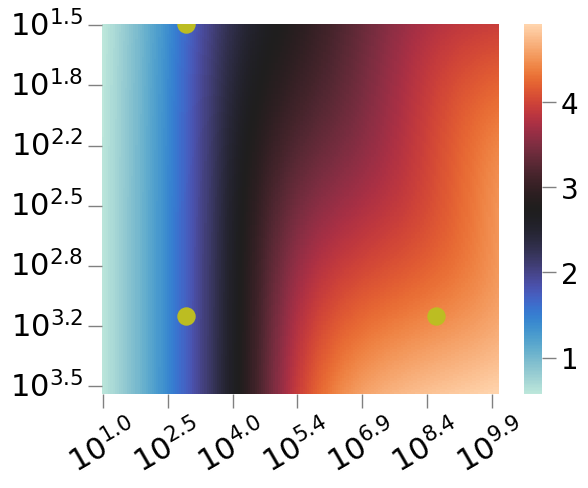

In [106]:
ax = sns.heatmap(
    np.log10(pivot_tauC/pivot_tauB),
#     pivot_tauB/pivot_tauA,
#     vmin=0, vmax=1, 
    cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax, highlights=([40, 40, 160],[0, 160, 160]))

plt.show()

##### $\tau_C/\tau_A$

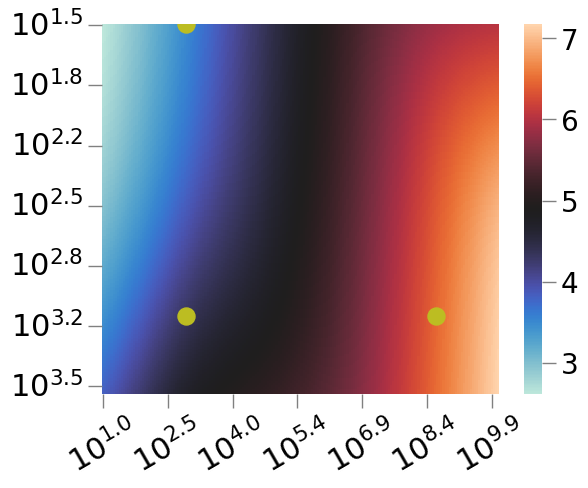

In [108]:
ax = sns.heatmap(
    np.log10(pivot_tauC/pivot_tauA),
#     pivot_tauB/pivot_tauA,
#     vmin=0, vmax=1, 
    cmap=sns.color_palette("icefire", as_cmap=True),
    xticklabels=31, yticklabels=33,
)

set_heatmap_parameters(ax, highlights=([40, 40, 160],[0, 160, 160]))

plt.show()

# NERDSS Input

```python
area3Dto1D = 100
P = 2
S = 2
N = 10+12

# reactions 1:
KPN = 33.211556
KPS = 33211.558
KPP = 1333.5864
# reactions 2:
KPN = 1274.8164
KPS = 1274816.4
KPP = 1333.5864
# reactions 3:
KPN = 1274.8164
KPS = 1274816.4
KPP = 690727692
```

# Numerical result for NERDSS datapoints

In [69]:
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num

from Simulations.odeSolver.doubleS import rxnNetwork as rxnC, labels as labelsC
from Simulations.odeSolver.singleS import rxnNetwork as rxnB, labels as labelsB
from Simulations.odeSolver.Nonly import rxnNetwork as rxnA, labels as labelsA
from Simulations.odeSolver.main import main as numericSolver

from GenerateParameters import GenParameters

In [70]:
def showDifferences(parm_Nonly, parm_Target):
    equi_A = numericSolver(parm_Nonly, labels=labelsA, model=rxnA, ifprint=False)
    equi_B = numericSolver(parm_Target, labels=labelsB, model=rxnB, ifprint=False)
    equi_C = numericSolver(parm_Target, labels=labelsC, model=rxnC, ifprint=False)
    
    nSize = parm_Nonly.shape[0]
    pBound_Nonly = np.zeros(nSize)
    pBound_singleS = np.zeros(nSize)
    pBound_doubleS = np.zeros(nSize)
    resT_Nonly = np.zeros(nSize)
    resT_singleS = np.zeros(nSize)
    resT_doubleS = np.zeros(nSize)
    for i in range(nSize):
        pBound_Nonly[i] = num.calc_BoundRatio_modelA(parm_Nonly.iloc[i], equi_A.iloc[i])
        pBound_singleS[i] = num.calc_BoundRatio_modelB(parm_Target.iloc[i], equi_B.iloc[i])
        pBound_doubleS[i] = num.calc_BoundRatio_modelC(parm_Target.iloc[i], equi_C.iloc[i])
        resT_Nonly[i] = num.calc_resT_modelA(parm_Nonly.iloc[i], equi_A.iloc[i])
        resT_singleS[i] = num.calc_resT_modelB(parm_Target.iloc[i], equi_B.iloc[i])
        resT_doubleS[i] = num.calc_resT_modelC(parm_Target.iloc[i], equi_C.iloc[i])
        
    kppList = np.unique(parm_Target['KPP'])
    kpnList = np.unique(parm_Target['KPN'])
    for kpn in kpnList:
        for kpp in kppList:
            selected = ( (parm_Nonly['KPP']==kpp) & (parm_Nonly['KPN']==kpn) )
            print('KPP=10^%.1f KPN=10^%.1f'%(np.log10(kpp*0.6022), np.log10(kpn*0.6022)))
            print('pBound: B-A:\t%.2f\tC-B:\t%.2f\tC-A:\t%.2f'%(
                pBound_singleS[selected]-pBound_Nonly[selected],
                pBound_doubleS[selected]-pBound_singleS[selected],
                pBound_doubleS[selected]-pBound_Nonly[selected],
            ))
            print('resT  : A:\t10^%.1f\tB:\t10^%.1f\tC:\t10^%.1f'%(
                np.log10(resT_Nonly[selected]),
                np.log10(resT_singleS[selected]),
                np.log10(resT_doubleS[selected]),
            ))

In [86]:
GenParm = lambda NS, scale: GenParameters(
    numTargets=NS, KPN = [10,], kbPP_fixed=0.1,
    kaPN=100000, kaPS=20000, lengthScale=scale,
    NP0 = [2], area3Dto1D = [10], KPP = [0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6],
)
scale = 2
NS = 2
parm_Nonly = GenParm(0, scale)
parm_Target = GenParm(NS, scale)
showDifferences(parm_Nonly, parm_Target)

KPP=10^-inf KPN=10^1.0
pBound: B-A:	0.44	C-B:	-0.11	C-A:	0.33
resT  : A:	10^-3.8	B:	10^-1.8	C:	10^-2.0
KPP=10^1.0 KPN=10^1.0
pBound: B-A:	0.44	C-B:	0.27	C-A:	0.71
resT  : A:	10^-3.8	B:	10^-1.8	C:	10^-1.3
KPP=10^2.0 KPN=10^1.0
pBound: B-A:	0.45	C-B:	0.41	C-A:	0.86
resT  : A:	10^-3.8	B:	10^-1.8	C:	10^-0.9
KPP=10^3.0 KPN=10^1.0
pBound: B-A:	0.48	C-B:	0.44	C-A:	0.93
resT  : A:	10^-3.7	B:	10^-1.8	C:	10^-0.5
KPP=10^4.0 KPN=10^1.0
pBound: B-A:	0.59	C-B:	0.36	C-A:	0.95
resT  : A:	10^-3.7	B:	10^-1.6	C:	10^-0.2
KPP=10^5.0 KPN=10^1.0
pBound: B-A:	0.68	C-B:	0.28	C-A:	0.96
resT  : A:	10^-3.6	B:	10^-1.5	C:	10^0.0
KPP=10^6.0 KPN=10^1.0
pBound: B-A:	0.72	C-B:	0.24	C-A:	0.97
resT  : A:	10^-3.6	B:	10^-1.5	C:	10^0.2


/tmp/ipykernel_8830/4125403491.py:26: RuntimeWarning: divide by zero encountered in log10
  print('KPP=10^%.1f KPN=10^%.1f'%(np.log10(kpp*0.6022), np.log10(kpn*0.6022)))


In [90]:
parm_Target['kaPP']*0.6022*1e-6

0    0.000000e+00
1    1.000000e-06
2    1.000000e-05
3    1.000000e-04
4    1.000000e-03
5    1.000000e-02
6    1.000000e-01
Name: kaPP, dtype: float64

In [168]:
scale = 3
NS = 3
parm_Nonly = GenParm(0, scale)
parm_Target = GenParm(NS, scale)
showDifferences(parm_Nonly, parm_Target)

KPP=10^-inf KPN=10^1.0
pBound: B-A:	0.49	C-B:	-0.09	C-A:	0.40
resT  : A:	10^-3.8	B:	10^-1.7	C:	10^-1.9
KPP=10^6.0 KPN=10^1.0
pBound: B-A:	0.75	C-B:	0.22	C-A:	0.97
resT  : A:	10^-3.6	B:	10^-1.4	C:	10^1.2


/tmp/ipykernel_2341414/4125403491.py:26: RuntimeWarning: divide by zero encountered in log10
  print('KPP=10^%.1f KPN=10^%.1f'%(np.log10(kpp*0.6022), np.log10(kpn*0.6022)))


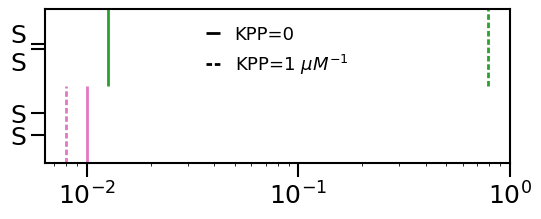

In [8]:
plt.figure(figsize=(6,2))
plt.tick_params(length=10, width=1.5)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.5)
    
plt.vlines(10**(-2.0), 0.5, 32, color='tab:pink', lw=2)
plt.vlines(10**(-1.9), 32, 64-0.5, color='tab:green', lw=2)
plt.vlines(10**(-2.1), 0.5, 32, color='tab:pink', ls=(0,(2,1)), lw=2)
plt.vlines(10**(-0.1), 32, 64-0.5, color='tab:green', ls=(0,(2,1)), lw=2)

plt.plot([],[],lw=2,ls=(0,(1,0)), label='KPP=0', color='black')
plt.plot([],[],lw=2,ls=(0,(2,1)), label='KPP=1 $\\mu M^{-1}$', color='black')

plt.semilogx()
plt.ylim([0.5,64-0.5])
plt.yticks([12, 21, 47, 49], ['S', 'S', '', 'S\nS'], fontsize=18)
plt.xticks(fontsize=18)

plt.legend(handlelength=0.8, loc='upper center', framealpha=0, fontsize=13)
plt.show()

# Plot Spatiotemporal Data - new version

In [3]:
class PDB_NERDSS():
    
    def __init__(self, parentDir='', pdbWrite=1e5):
        self._pdir = parentDir
        self._pdbStep = pdbWrite
        self.t = []
        self.x = []
        self.r = []
        self.proteinNumbers = []
        self.left = []
        self.right = []
        self.t_longest = []
        self.x_all = []
        self.x_onDNA = []
    
    def read_pdbs(self, N_repeat=None, pdbMin=0, pdbMax=np.inf, YZcenter=31.623/2, timeStep:float=1e-6):
        '''Read pdbs untill pdbMax
        
        Args:
        
            N_repeat (int, iterable): 
                (int) the number of repeats, will read subfolders named in `range(N_repeat)`
                (iterable of strings) the names of subfolders
            
            pdbMin (int): The min index (number of steps) of pdb read.
            
            pdbMax (int): The max index (number of steps) of pdb read.
            
            YZcenter (float): The center coordinate of Y and Z axes (they are the same) used to calculate r.
            
            timeStep (float): time jump for one step.
            
        Returns:
            None: 
                self.x (list of lists): x coordinates
                self.r (list of lists): r distances
                self.t (list of lists): time points
                self.t_longest (list): the longest time points
        '''
        
        self._pdbMax = pdbMax
        self._YZcenter = YZcenter
        self._tStep = timeStep
        
        if N_repeat is None:
            self._subnames = ['']
        elif isinstance(N_repeat, int):
            self._subnames = [str(i) for i in range(N_repeat)]
        else: # assume it is iterable
            self._subnames = [str(i) for i in N_repeat]
        self._Nrepeats = len(self._subnames)
        
        for subname in self._subnames:
            x = []
            r = []
            t = []
            NItr = pdbMin # include the initial coordinates
            while NItr < self._pdbMax:
                # in case the simulation does not run through pdbMax*pdbStep
                filename = int(NItr*self._pdbStep)
                x_itr = []
                r_itr = []
                try:
                    with open(f'{self._pdir}/{subname}/PDB/{filename}.pdb') as f:
                        for line in f:
                            linelist = line.split()
                            if linelist[2] == 'COM' and linelist[3] == 'P':
                                x_itr.append(float(linelist[5]))
                                CRDy = float(linelist[6])
                                CRDz = float(linelist[7])
                                r_itr.append(
                                    ((CRDy-self._YZcenter)**2 + (CRDz-self._YZcenter)**2)**0.5
                                )
                    t.append(NItr*self._pdbStep*self._tStep)
                    NItr += 1
                except:
                    break
                x.append(x_itr)
                r.append(r_itr)
            self.x.append(x)
            self.r.append(r)
            self.t.append(t)
        
        self._subnames = [name for i, name in enumerate(self._subnames) if len(self.t[i]) != 0]
        self._Nrepeats = len(self._subnames)
        self.x = [x for i, x in enumerate(self.x) if len(self.t[i]) != 0]
        self.r = [r for i, r in enumerate(self.r) if len(self.t[i]) != 0]
        self.t = [t for t in self.t if len(t)!=0]
                
        
        self.t_longest = self.t[0]
        for t in self.t:
            if len(t) > len(self.t_longest):
                self.t_longest = t
        self.left = np.zeros_like(self.t_longest)
        self.right = np.zeros_like(self.t_longest)
    
    def classify_proteins(self, burnInSteps=1, windowMax=10, chromRadius=5.5, Xcenter=64/2):
        '''Classify proteins into different regions
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
            windowMax (int): 
                The max window size used for calculating avarages. 
                There should be windowMax >= burnInSteps, otherwise windowMax = burnInSteps
            
            chromRadius (float): 
                The radius of chromatin. When r < chromRadius, this protein is considered as lying on DNA.
                Set this to np.inf to count all proteins in solution.
            
            Xcenter (float): The center of X axis. 
            
        Returns:
            None: 
                self.left (1darray): the probabilities of proteins in left
                self.right (1darray): the probabilities of proteins in right
                They are normalized to the total number of proteins.
        '''
        
        self._pdbNumMin = burnInSteps
        self._windowMax = max(windowMax, burnInSteps)
        self._chromR = chromRadius
        self._Xcenter = Xcenter
        
        left = []
        right = []
        self._copies = np.zeros_like(self.t_longest)
        for nr in range(self._Nrepeats):
            xn = np.array(self.x[nr])
            rn = np.array(self.r[nr])
            leftn = np.zeros(xn.shape[0])
            rightn = np.zeros(xn.shape[0])
            numPs = xn.shape[1]
            if numPs == 0:
                pass
            else:
                for ip in range(numPs):
                    leftn[ (xn[:,ip] < Xcenter) & (rn[:,ip] < chromRadius) ] += 1
                    rightn[ (xn[:,ip] > Xcenter) & (rn[:,ip] < chromRadius) ] += 1
                leftn[:self._pdbNumMin] = leftn[self._pdbNumMin]
                rightn[:self._pdbNumMin] = rightn[self._pdbNumMin]
                # now, left and right are the probabilities at the relavant timepoint
                left.append(leftn/numPs)
                right.append(rightn/numPs)
        
        for NItr in range(0, len(self.t_longest)):
            leftNItr = [ np.mean(left[nr][max(0,NItr-self._windowMax+1) : NItr+1]) for nr in range(self._Nrepeats) ]
            rightNItr = [ np.mean(right[nr][max(0,NItr-self._windowMax+1) : NItr+1]) for nr in range(self._Nrepeats) ]
#             print(leftNItr)
            self.left[NItr] = np.mean(leftNItr)
            self.right[NItr] = np.mean(rightNItr)

    def find_proteins_on_DNA(self, burnInSteps=0, chromRadius=5.5):
        '''Find proteins that are close to DNA
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
            chromRadius (float): 
                The radius of chromatin. When r < chromRadius, this protein is considered as lying on DNA.
                Set this to np.inf to count all proteins in solution.
            
        Returns:
            None: 
                self.x_onDNA (1darray): the x coordinates of proteins on DNA
                self.totNumProtein (int): the total number of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self._chromR = chromRadius
        
        self.x_onDNA = []
        self.totNumProtein = 0
        
        for nr in range(0, self._Nrepeats):
            r_nr = np.array(self.r[nr])
            x_nr = np.array(self.x[nr])
            numPs = x_nr.shape[1]
            for ip in range(numPs):
                x_nr_ip = x_nr[self._pdbNumMin:, ip]
                r_nr_ip = r_nr[self._pdbNumMin:, ip]
                self.x_onDNA += [x for x in x_nr_ip[r_nr_ip < self._chromR]]
                self.totNumProtein += len(x_nr_ip)
            
    def get_all_x(self, burnInSteps=1):
        '''collect all x coordinates of proteins
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
        Returns:
            self.x_all (list): The x coordinates of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self.x_all = []
        
        for nr in range(0, self._Nrepeats):
            self.x_all += [x for x in self.x[nr][self._pdbNumMin:]]
        
        return self.x_all
        

In [4]:
def plothist(data, binEdges, normalization, color, ax, style='stairs'):
    hist, bin_edges = np.histogram(data, bins=binEdges, density=False)
    if style=='stairs':
        ax.stairs(hist/normalization, bin_edges, fill=True, color=color)
    elif style=='curve':
        ax.plot((bin_edges[1:]+bin_edges[:-1])/2, hist/normalization, color=color)
        
def plotSpatialDistributions(
    data, burnIn, ax,
    binEdgesOnDNA=np.arange(0+5.5,64-5.5,1),
    binEdgesAll=np.arange(0.5,64,1),
    axLineW=1.5, 
):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(axLineW)
    plothist(
        data.x_onDNA, binEdgesOnDNA, 
        data.totNumProtein, 
        'tab:blue', ax, style='stairs'
    )
    plothist(
        data.get_all_x(burnIn), binEdgesAll, 
        data.totNumProtein, 
        'tab:red', ax, style='curve'
    )

    plt.semilogy()

    plt.xlim([0.5,64-0.5])
    plt.xticks([15, 17, 43, 52], ['S ', ' S', 'S', 'S'], fontsize=18)
    plt.ylim([1e-3,1e0])
    plt.yticks(fontsize=18)

In [5]:
def drawHists(
    pdbs_1, pdbs_2, ylim, burnIn, xlength, histWidth=1, figsize=(16,2),
    SCrds = [-39.0, -37.0, -35.0, 18.5, 37.0, 55.5],
    SLabels = ['', 'SSS', '', 'S', 'S', 'S'], 
    offset=0, fontsize=18, linewidth=1.5, tickL=10, tickW=2,
):
    plt.figure(figsize=figsize)
    plt.subplots_adjust(wspace=0)
    ax = plt.subplot(121)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(linewidth)
    plt.tick_params(length=tickL, width=tickW)
    
    plothist(
        pdbs_1.x_onDNA, np.arange(0+5.5+offset,xlength-5.5,histWidth), 
        pdbs_1.totNumProtein, 
        'tab:blue', ax, style='stairs'
    )
    plothist(
        pdbs_1.get_all_x(burnIn), np.arange(0.5+offset,xlength,histWidth), 
        pdbs_1.totNumProtein, 
        'tab:red', ax, style='curve'
    )

    plt.semilogy()
    plt.xlim([0.5,xlength-0.5])
    plt.xticks(np.array(SCrds)+xlength/2, SLabels, fontsize=fontsize)
    plt.ylim(ylim)
    plt.yticks(fontsize=fontsize)

    ax = plt.subplot(122)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(linewidth)
    plt.tick_params(length=tickL, width=tickW)
    plothist(
        pdbs_2.x_onDNA, np.arange(0+5.5+offset,xlength-5.5,histWidth), 
        pdbs_2.totNumProtein, 
        'tab:blue', ax, style='stairs'
    )
    plothist(
        pdbs_2.get_all_x(burnIn), np.arange(0.5+offset,xlength,histWidth), 
        pdbs_2.totNumProtein, 
        'tab:red', ax, style='curve'
    )
    
    plt.semilogy()
    plt.xlim([0.5,xlength-0.5])
    plt.xticks(np.array(SCrds)+xlength/2, SLabels, fontsize=fontsize)
    plt.ylim(ylim)
    plt.yticks([])

In [6]:
def selectivity(pdbs, xlength):
    pdbs.x_onDNA = np.array(pdbs.x_onDNA)
    numProteins_right = np.sum(pdbs.x_onDNA > xlength/2)
    if numProteins_right == 0:
        return len(pdbs.x_onDNA) / 1
    else:
        return (np.sum(pdbs.x_onDNA < xlength/2)/numProteins_right)

## dimers

In [58]:
simDirs = 'kpp0kpnE1.0  kppE1.0kpnE1.0  kppE2.0kpnE1.0  kppE3.0kpnE1.0  kppE4.0kpnE1.0  kppE5.0kpnE1.0  kppE6.0kpnE1.0'.split()
PDBS = []
for simdir in progressbar(simDirs):
    PDBS.append(PDB_NERDSS(f'../Simulations/NERDSS/twoSegments/{simdir}/', 1e5))
    PDBS[-1].read_pdbs(N_repeat=200, pdbMin=499-0)

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [59]:
burnIn = 0
xlength = 106
slcList = []
for pdbs in progressbar(PDBS):
    pdbs.find_proteins_on_DNA(burnIn)
    slcList.append(selectivity(pdbs, xlength))

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [60]:
slcList

[0.7155172413793104, 1.196078431372549, 3.85, 37.2, 196.5, 199.0, 132.0]

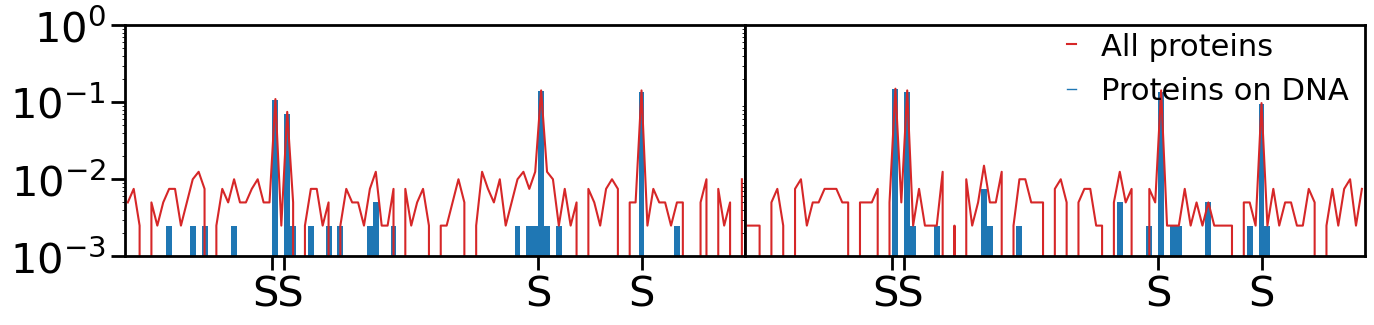

In [61]:
ylim = [1e-3, 1]

drawHists(
    PDBS[0], PDBS[1], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

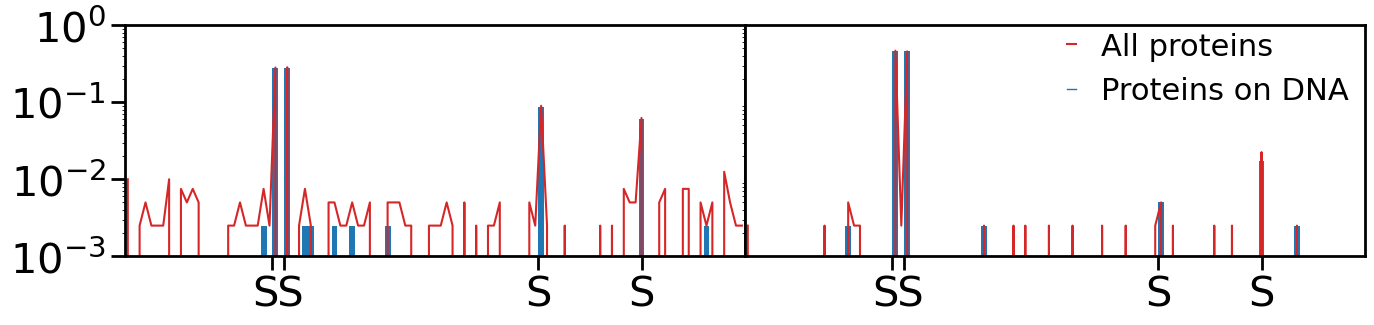

In [62]:
ylim = [1e-3, 1]

drawHists(
    PDBS[2], PDBS[3], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

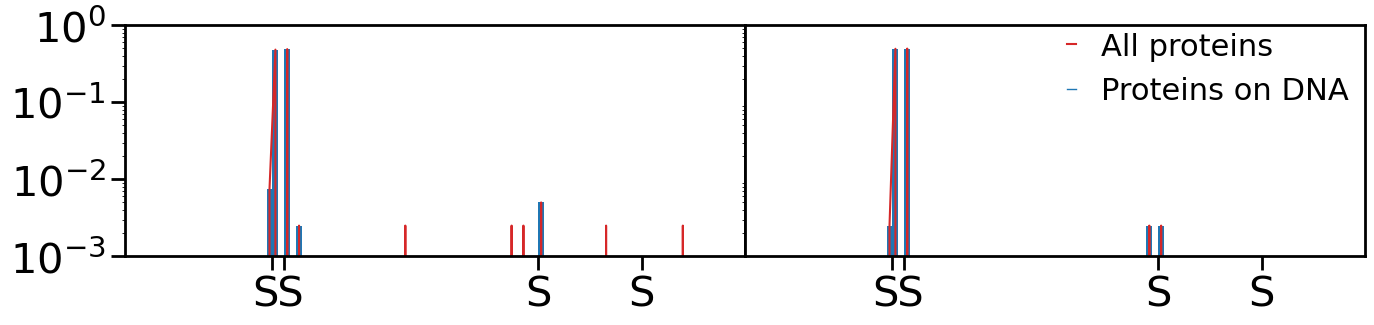

In [63]:
ylim = [1e-3, 1]

drawHists(
    PDBS[4], PDBS[5], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

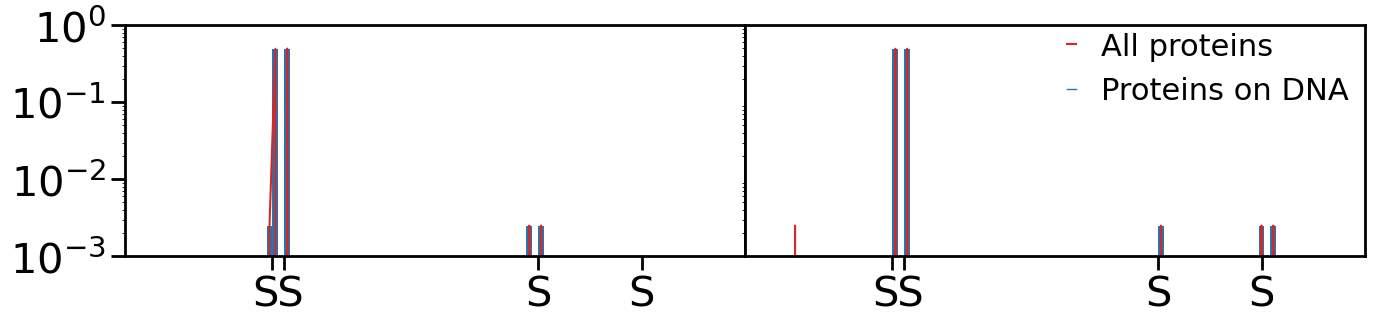

In [64]:
ylim = [1e-3, 1]

drawHists(
    PDBS[5], PDBS[6], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

### check equilibrium

In [80]:
from myutils.nerdssData import nerdssData

In [120]:
nd = nerdssData(100, '../Simulations/NERDSS/twoSegments/kppE2.0kpnE1.0/', ifprint=False)
nd.readHist('DATA/histogram_complexes_time.dat', ifprint=False)
print(nd.MOLNAMES)

['nuc: 1.', 'S: 1.', 'N: 1.', 'P: 1.', 'S: 2.', 'P: 1. S: 1.', 'P: 1. S: 2.', 'P: 1. N: 1. S: 1.', 'P: 1. N: 1. S: 2.', 'P: 1. N: 1.', 'P: 2. S: 2.', 'P: 2. N: 1. S: 2.', 'P: 2. N: 2. S: 2.', 'P: 2. S: 1.', 'P: 2.', 'P: 2. N: 2. S: 1.', 'P: 2. N: 1. S: 1.']


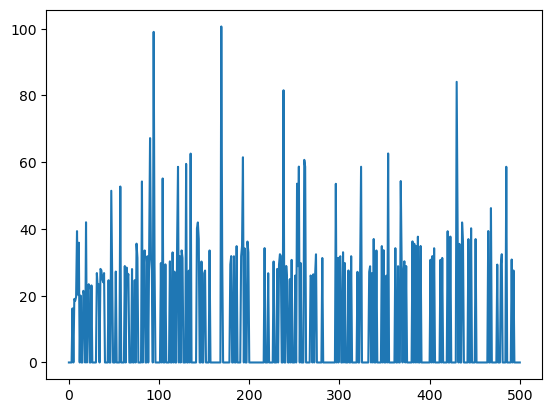

In [122]:
vtot = 1000*106 # nm^3
plt.plot(vtot*nd.MOLS['P: 1. N: 1.'] / nd.MOLS['P: 1.'] / nd.MOLS['N: 1.'] * 0.6022)

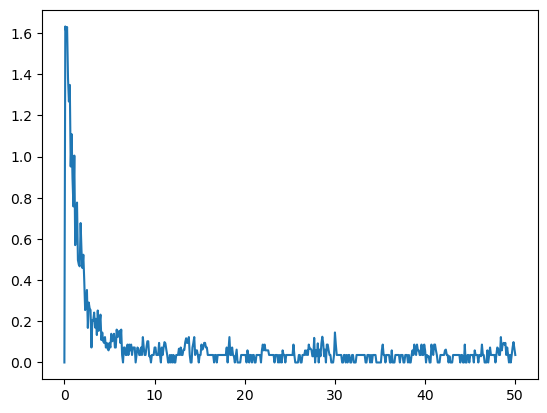

In [102]:
plt.plot(
    nd.time, 
    nd.MOLS['P: 1. S: 1.']+nd.MOLS['P: 1. N: 1. S: 1.']\
    +2*(nd.MOLS['P: 2. S: 1.']+nd.MOLS['P: 2. N: 1. S: 1.']+nd.MOLS['P: 2. N: 2. S: 1.'])
)

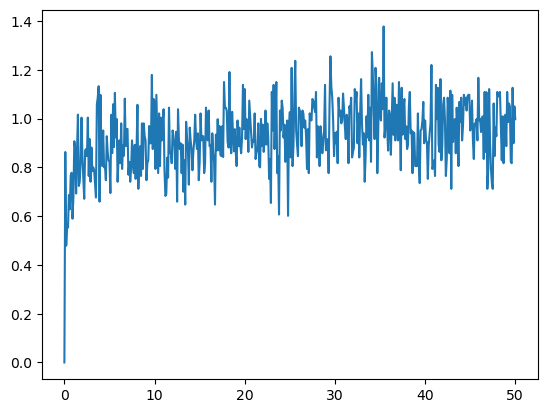

In [86]:
plt.plot(
    nd.time, 
    nd.MOLS['P: 1. N: 1. S: 2.']+nd.MOLS['P: 1. S: 2.']\
    +2*(nd.MOLS['P: 2. N: 2. S: 2.']+nd.MOLS['P: 2. N: 1. S: 2.'])
)

## dimers kpp = 1e1 and 1e2

In [41]:
from myutils.nerdssData import nerdssData

In [58]:
ndsim = nerdssData(100, '../Simulations/NERDSS/twoSegments/kpp0kpnE1.0/')

>>>>>> parsing ../Simulations/NERDSS/twoSegments/kppE2.0kpnE1.0/
WaterBox = [106, 31.623, 31.623] # VtoL=4000
{'P': 2, 'N': 44, 'S': 4, 'nuc': 3}
Reactions:
N(ref) + nuc(ref) -> N(ref!1).nuc(ref!1)
P(ref) + nuc(ref) -> P(ref!1).nuc(ref!1)
S(re1) + S(re2) -> S(re1!1).S(re2!1)
S(bs) + P(dbs) <-> S(bs!1).P(dbs!1)
N(bs) + P(dbn) <-> N(bs!1).P(dbn!1)
P(pp1) + P(pp2) <-> P(pp1!1).P(pp2!1)
<<<<<< finished parsing
------------------------------------------------------


In [59]:
ndsim.readHist('DATA/histogram_complexes_time.dat', ifprint=False)
ndsim.MOLNAMES

['nuc: 1.',
 'S: 1.',
 'N: 1.',
 'P: 1.',
 'P: 1. S: 2.',
 'P: 1. S: 1.',
 'S: 2.',
 'P: 1. N: 1. S: 1.',
 'P: 2. S: 2.',
 'P: 1. N: 1. S: 2.',
 'P: 1. N: 1.',
 'P: 2. N: 1. S: 2.',
 'P: 2. N: 2. S: 2.',
 'P: 2.']

<ErrorbarContainer object of 3 artists>

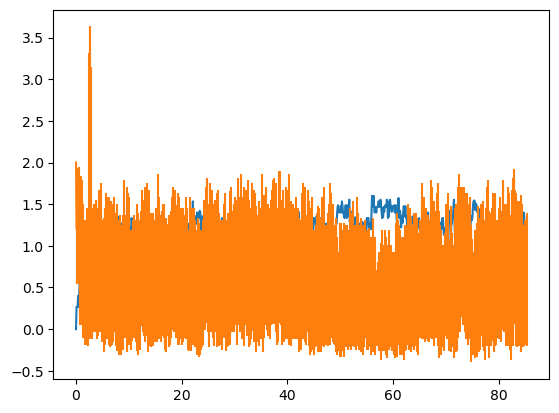

In [68]:
plt.plot(
    ndsim.time, 
    2*(ndsim.MOLS['P: 2. N: 2. S: 2.']+ndsim.MOLS['P: 2. N: 1. S: 2.']+ndsim.MOLS['P: 2. S: 2.'])\
    +ndsim.MOLS['P: 1. N: 1. S: 2.']+ndsim.MOLS['P: 1. S: 2.']
)
plt.errorbar(
    ndsim.time, 
    ndsim.MOLS[ 'P: 1.']+2*ndsim.MOLS[ 'P: 2.'],
    ndsim.MOLS_err[ 'P: 1.']+2*ndsim.MOLS_err[ 'P: 2.']
)

In [30]:
pdbs_1 = PDB_NERDSS('../Simulations/NERDSS/twoSegments/kppE1.0kpnE1.0//', 1e5)
pdbs_1.read_pdbs(N_repeat=15)
pdbs_2 = PDB_NERDSS('../Simulations/NERDSS/twoSegments/kppE2.0kpnE1.0/', 1e5)
pdbs_2.read_pdbs(N_repeat=15)

In [32]:
print([round(t[-1],1) for t in pdbs_1.t])
print([round(t[-1],1) for t in pdbs_2.t])

[106.6, 98.7, 110.1, 106.9, 35.8, 106.6, 107.1, 107.1, 113.2, 108.8, 110.4, 111.0, 110.9, 108.3, 114.4]
[108.1, 108.3, 111.7, 112.0, 109.6, 110.7, 110.4, 107.0, 105.1, 106.8, 108.6, 107.6, 108.3, 85.3, 106.4]


In [33]:
burnIn = 200
xlength = 106
pdbs_1.find_proteins_on_DNA(burnIn)
pdbs_2.find_proteins_on_DNA(burnIn)

In [37]:
selectivity(pdbs_1), selectivity(pdbs_2)

(0.10889839422200406, 0.6170299449989814)

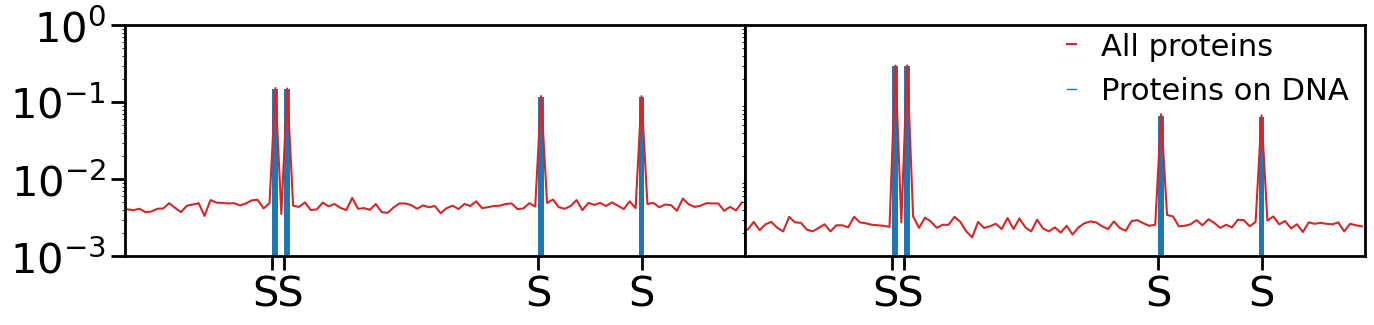

In [35]:
ylim = [1e-3, 1]

drawHists(
    pdbs_1, pdbs_2, ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

## multimer in a row

In [88]:
pdbs_0 = PDB_NERDSS('../Simulations/NERDSS/twoSegments_trimer/kpp0kpnE1.0/', 1e5)
pdbs_0.read_pdbs(N_repeat=15)
pdbs_6 = PDB_NERDSS('../Simulations/NERDSS/twoSegments_trimer/kppE6.0kpnE1.0/', 1e5)
pdbs_6.read_pdbs(N_repeat=15)
# pdbs_6_1_4 = PDB_NERDSS('../Simulations/NERDSS/kppE6kpnE1kpsE4_C_B/', 1e5)
# pdbs_6_1_4.read_pdbs(N_repeat=10)

In [89]:
print([round(t[-1],1) for t in pdbs_0.t])
print([round(t[-1],1) for t in pdbs_6.t])

[149.5, 145.3, 126.3, 148.7, 148.2, 142.3, 152.1, 149.8, 81.0, 148.4, 146.7, 154.9, 146.0, 148.4, 139.8]
[154.2, 150.6, 144.7, 144.0, 146.3, 151.1, 152.9, 146.3, 147.7, 146.9, 146.0, 148.0, 152.7, 149.3, 153.2]


In [90]:
burnIn = 200
xlength = 148
pdbs_0.find_proteins_on_DNA(burnIn)
pdbs_6.find_proteins_on_DNA(burnIn)

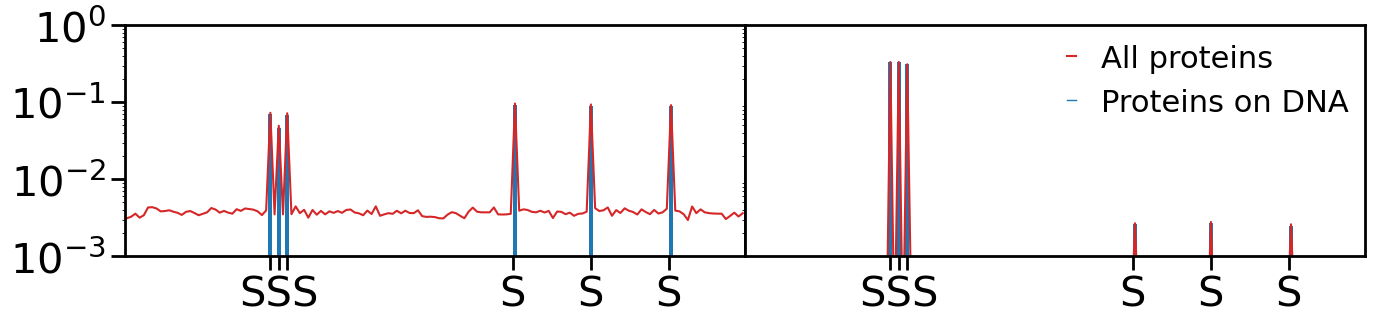

In [92]:
ylim = [1e-3, 1]

drawHists(
    pdbs_0, pdbs_6, ylim, burnIn, xlength,
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.55], framealpha=0.0, fontsize=22)

plt.show()

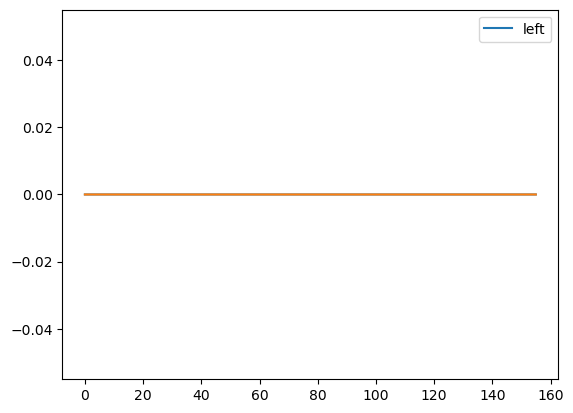

In [91]:
# pdbs_0.classify_proteins(burnIn, Xcenter=xlength/2)
# pdbs_6.classify_proteins(burnIn, Xcenter=xlength/2)
# pdbsdata = pdbs_0
# plt.plot(pdbsdata.t_longest, pdbsdata.left, label='left')
# plt.plot(pdbsdata.t_longest, pdbsdata.right)
# plt.legend()

In [ ]:
from process_AD import readResT_from_NERDSS
def get_survival_prob(resident_times, bins=100):

    # get survival probabilities
    h = np.histogram(resident_times, bins=bins, density=True)
    return h[1], np.append([1], 1 - np.cumsum(h[0]*np.diff(h[1])))

In [41]:
pfolder = '../Simulations/NERDSS/twoSegments_trimer/kppE6.0kpnE1.0/'
resTime_nerdss = []
resTime_means = []
for i in range(15):
    try:
        datafile = f'{pfolder}/{i}/DATA/assoc_dissoc_time.dat'
        resTi, _ = readResT_from_NERDSS(datafile, dt=1e-6, startT=20)
        if len(resTi) == 0:
            print(i, 'no residence time found')
        else:
            resTime_nerdss.append(resTi)
            resTime_means.append(np.mean(resTi))
    except:
        print(i)

0
1 no residence time found
2
4
5
6
7
8
9
10
11 no residence time found
12
13
14 no residence time found


In [42]:
[len(i) for i in resTime_nerdss]

[2240]

In [43]:
timeUpperLimit = 300
binwidth = 0.01
times = []
survP = []
for resT_nerdss_i in resTime_nerdss:
    times_i_fit, survP_i_fit = get_survival_prob(resT_nerdss_i, np.arange(0, timeUpperLimit, binwidth))
    times.append(times_i_fit)
    survP.append(survP_i_fit)

[]

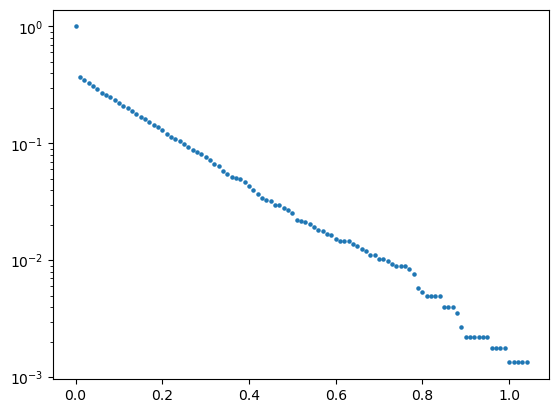

In [44]:
for i in range(len(times)):
    plt.scatter(times[i][survP[i]>1e-3], survP[i][survP[i]>1e-3], s=5)
plt.semilogy()

# Selectivity

In [7]:
import sys
from scipy.optimize import fsolve, root_scalar
sys.path.append('/home/local/WIN/msang2/mankun/Notebooks/[01]dimerEnhanceProteinDNA/')
# modules for direct calculation
import analytics as ana
import analyzeEqui as num
# stochastic simulation (Gillespie)
# from Simulations.odeSolver.reversible.singleS import labels
from Simulations.odeSolver.doubleS import rxnNetwork as rxnDoubleS, labels as labelsDoubleS
from Simulations.odeSolver.singleS import rxnNetwork as rxnSingleS, labels as labelsSingleS
from Simulations.odeSolver.Nonly import rxnNetwork as rxnNonly, labels as labelsNonly
from Simulations.odeSolver.main import main as numericSolver
# for generating parameters
from GenerateParameters import GenParameters

In [8]:
GenParms = lambda NP0, NS, scale, KPP: GenParameters(
    numTargets=NS, NP0=NP0, KPP=[KPP], KPN=[10], area3Dto1D=[10], lengthScale=scale
)

In [9]:
def freeProDiff(NP1, Ntot = 6, NS = 3, scale = 3, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return -((Ntot-N1)*(1-theta2))[0]
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return (N1*(1-theta1) - (Ntot-N1)*(1-theta2))[0]
    
def pBoundRatios(NP1, Ntot = 6, NS = 3, scale = 3, KPP = 1e6):
    if isinstance(NP1, (np.int_, np.float_, float, int)):
        N1 = np.array([NP1])
    else:
        N1 = NP1
    
    if N1[0] < 1e-9:
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return 0, theta2
    else:
        parm1 = GenParms(N1, NS, scale, KPP)
        parm2 = GenParms(Ntot - N1, NS, scale, KPP)
        equi1 = numericSolver(parm1, rxnSingleS, labelsSingleS, ifprint=False)
        equi2 = numericSolver(parm2, rxnDoubleS, labelsDoubleS, ifprint=False)
        theta1 = num.calc_BoundRatio_modelB(parm=parm1.iloc[0], equi=equi1.iloc[0])
        theta2 = num.calc_BoundRatio_modelC(parm=parm2.iloc[0], equi=equi2.iloc[0])
        return theta1, theta2
    
def proteinsOnDNA(N1, Ntot, theta1, theta2):
    return theta1*(N1), theta2*(Ntot - N1)

In [10]:
KPPList = 10.0**np.arange(0,7.01,0.25)
N1_dimer = []

for Ntot in [2, 4]:
    N1_n = []
    for kpp in progressbar(KPPList):
        r_dimer = root_scalar(freeProDiff, x0=Ntot/2, x1=Ntot/2*0.9, xtol=1e-6, args=(Ntot, 2, 2, kpp))
        N1_n.append(r_dimer.root)
    N1_dimer.append(N1_n)

N1_dimer = np.array(N1_dimer)

100% (29 of 29) |########################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (29 of 29) |########################| Elapsed Time: 0:00:22 Time:  0:00:22


In [11]:
theta1 = []
theta2 = []
clustered_onDNA = []
separated_onDNA = []
for i, Ptot in enumerate([2, 4]):
    th1_n = []
    th2_n = []
    spr_n = []
    cls_n = []
    for j in progressbar(range(len(KPPList))):
        kpp = KPPList[j]
        th1, th2 = pBoundRatios(N1_dimer[i][j], Ptot, 2, 2, kpp)
        spr, cls = proteinsOnDNA(N1_dimer[i][j], Ptot, th1, th2)
        cls_n.append(cls)
        spr_n.append(spr)
        th1_n.append(th1)
        th2_n.append(th2)
    clustered_onDNA.append(cls_n)
    separated_onDNA.append(spr_n)
    theta1.append(th1_n)
    theta2.append(th2_n)
clustered_onDNA = np.array(clustered_onDNA)
separated_onDNA = np.array(separated_onDNA)
theta1 = np.array(theta1)
theta2 = np.array(theta2)

100% (29 of 29) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (29 of 29) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


In [34]:
slcList_repeats_2pro = [[0.7580645161290323, 0.703125, 0.9818181818181818],
 [1.1132075471698113, 1.1538461538461537, 1.24],
 [2.851063829787234, 3.1136363636363638, 3.4146341463414633],
 [30.4, 23.153846153846153, 27.545454545454547],
 [152.5, 152.5, 75.75],
 [333.0, 166.0, 166.0],
 [336.0, 336.0, 335.0]]
slcList_repeats_4pro =  [[0.7355371900826446, 0.8584070796460177, 0.7948717948717948],
 [1.7432432432432432, 1.4457831325301205, 1.5696202531645569],
 [1.9834710743801653, 2.4056603773584904, 2.4711538461538463],
 [3.388235294117647, 3.1444444444444444, 3.010752688172043],
 [2.388888888888889, 2.7346938775510203, 2.6357615894039736],
 [2.1624548736462095, 2.2324723247232474, 2.1510791366906474],
 [3.2322097378277155, 3.109090909090909, 3.466403162055336]]
slcList_repeats = [slcList_repeats_2pro, slcList_repeats_4pro]

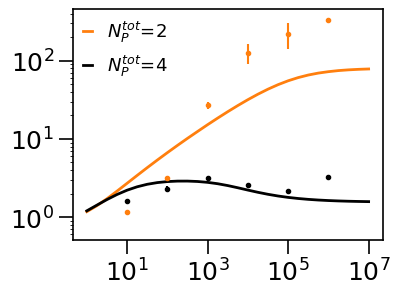

In [35]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
for i, slcRepeat in enumerate(slcList_repeats):
    plt.errorbar(
        np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
        np.mean(slcRepeat, axis=1), np.std(slcRepeat, axis=1), 
        ls='', color=colors[i], marker='.', #edgecolors='black', alpha=alphas[1], 
    )
    
for i, ntot in enumerate([2, 4]):
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.67], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

In [178]:
slcList_repeats = []
repeatID_pool = np.arange(100,300,1)

def selectivity(pdbs, xlength):
    pdbs.x_onDNA = np.array(pdbs.x_onDNA)
    numProteins_right = np.sum(pdbs.x_onDNA > xlength/2)
    if numProteins_right == 0:
        return len(pdbs.x_onDNA) / 1
    else:
        return (np.sum(pdbs.x_onDNA < xlength/2)/numProteins_right)

In [181]:
simDirs = 'kpp0kpnE1.0  kppE1.0kpnE1.0  kppE2.0kpnE1.0  kppE3.0kpnE1.0  kppE4.0kpnE1.0  kppE5.0kpnE1.0  kppE6.0kpnE1.0'.split()
PDBS = []
burnIn = 0
xlength = 106
slcList = []
for simdir in progressbar(simDirs):
    PDBS.append(PDB_NERDSS(f'../Simulations/NERDSS/twoSegments/{simdir}/', 1e5))
    PDBS[-1].read_pdbs(N_repeat=np.random.choice(repeatID_pool,50,replace=False), pdbMin=499-0)
    PDBS[-1].find_proteins_on_DNA(burnIn)
    slcList.append(selectivity(PDBS[-1], xlength))
slcList_repeats.append(slcList)

100% (7 of 7) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [168]:
np.std(slcList_repeats, axis=0)

array([ 0.17349746,  0.06815888,  1.05127788, 22.52529442,  1.24721913,
        0.        ,  0.        ])

In [169]:
simDirs = 'kpp0kpnE1.0  kppE1.0kpnE1.0  kppE2.0kpnE1.0  kppE3.0kpnE1.0  kppE4.0kpnE1.0  kppE5.0kpnE1.0  kppE6.0kpnE1.0'.split()
PDBS = []
burnIn = 0
xlength = 106
slcList = []
for simdir in progressbar(simDirs):
    PDBS.append(PDB_NERDSS(f'../Simulations/NERDSS/twoSegments/{simdir}/', 1e5))
    PDBS[-1].read_pdbs(N_repeat=repeatID_pool, pdbMin=499-0)
    PDBS[-1].find_proteins_on_DNA(burnIn)
    slcList.append(selectivity(PDBS[-1], xlength))

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [185]:
slcList_repeats_2 = [[0.8837209302325582,
  1.0571428571428572,
  3.3846153846153846,
  43.166666666666664,
  286.0,
  130.0,
  308.0],
 [0.8833333333333333,
  0.8888888888888888,
  3.088888888888889,
  62.0,
  356.0,
  332.0,
  338.0],
 [0.9090909090909091,
  1.015625,
  2.6551724137931036,
  39.625,
  298.0,
  330.0,
  334.0]]

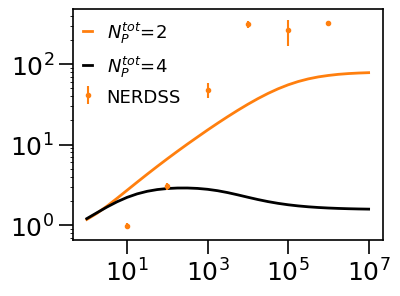

In [186]:
alphas = [1/3, 1]
colors = ['tab:orange', 'black']
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
    
plt.errorbar(
    np.array([0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]), 
    np.mean(slcList_repeats_2, axis=0), np.std(slcList_repeats_2, axis=0), ls='',
    color='tab:orange', #edgecolors='black', alpha=alphas[1], 
    marker='.', 
    label='NERDSS', zorder=3,
)
    
for i, ntot in enumerate([2, 4]):
#     plt.plot(
#         KPPList, ((clustered_onDNA-separated_onDNA)/(clustered_onDNA+separated_onDNA))[i], ls='-', 
#         label='$N_P^{tot}$=%d'%ntot, lw=2, color='tab:orange', alpha=alphas[i], zorder=1,
#     )
    plt.plot(
        KPPList, ((clustered_onDNA/separated_onDNA))[i], ls='-', 
        label='$N_P^{tot}$=%d'%ntot, lw=2, color=colors[i], #color='tab:orange', alpha=alphas[i], 
        zorder=1,
    )


# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.01,0.55], fontsize=13, handlelength=0.5, framealpha=0)
plt.loglog()
# plt.ylim([0.,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

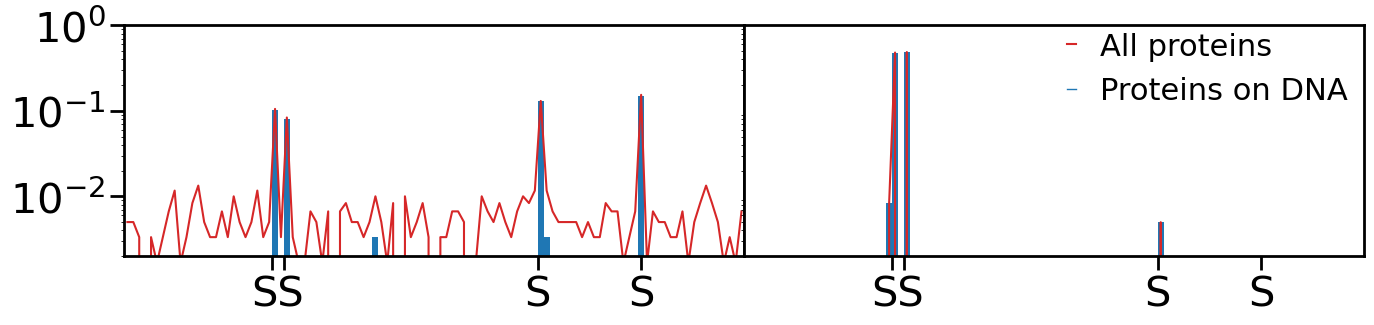

In [143]:
ylim = [2e-3, 1]

drawHists(
    PDBS[0], PDBS[4], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

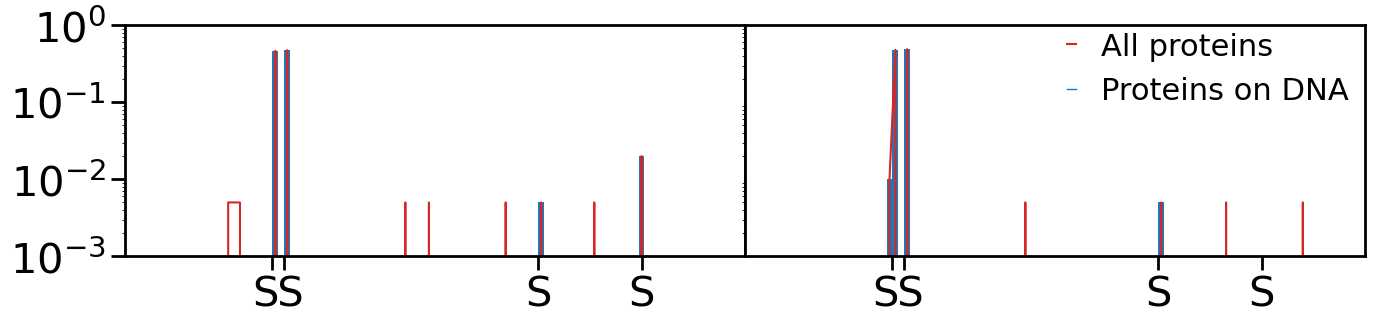

In [188]:
ylim = [1e-3, 1]

drawHists(
    PDBS[3], PDBS[4], ylim, burnIn, xlength,
    SCrds = [-27.5, -25.5, 17.5, 35.0],
    SLabels = ['S ', ' S', 'S', 'S'],
    histWidth=1, figsize=(16,3), fontsize=30, linewidth=2
)

plt.plot([],[], color='tab:red', label='All proteins')
plt.stairs([],[0], color='tab:blue', label='Proteins on DNA')
plt.legend(handlelength=0.3, loc=[0.5,0.6], framealpha=0.0, fontsize=22)

plt.show()

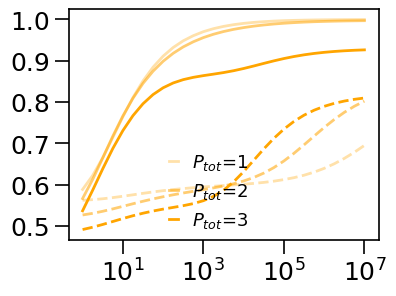

In [130]:
alphas = [3/9, 5/9, 1]
plt.figure(figsize=(4,3))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)
for i, ntot in enumerate([1,2,3]):
    plt.plot(
        KPPList, theta2[i], ls='-', 
        label='$P_{tot}$=%d'%ntot, lw=2, color='orange', alpha=alphas[i]
    )
    plt.plot(
        KPPList, theta1[i], ls='--', 
        lw=2, color='orange', alpha=alphas[i]
    )
# plt.title('proteins on DNA', fontsize=13)
plt.legend(loc=[0.3,0.01], fontsize=13, handlelength=0.5, framealpha=0)
plt.semilogx()
# plt.ylim([0.5,1.01])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Plot Spatiotemporal Data - old version

In [28]:
equis_2

,ID,S,N,P,PP,PN,PS,PSN,PPN,PPS,PPSN,PNPN,PSPN,PNPSN,PSPS,PSPSN,PSNPSN
0,0.0,646.448878,1.610589e+07,555.686438,16.278134,47.180573,1.893706,16.078514,2.764191,0.110947,0.941998,11.734685,0.941998,7.998034,5547.360804,94199.764986,399901.684631


In [2]:
# To reproduce data from PDB, please run this cell
# -----------------------------------------------------------------------------
# uncomment the following code to read the data from the PDB files
# -----------------------------------------------------------------------------

def readSpatialDist(parentDir, pdbWrite, nCalcLower = 11, windowmax=1000, nPDBread=np.inf):
    proteinCRDSx = []
    proteinCRDSr = []
    NItr = 1
    left = []
    right = []
    while NItr<nPDBread:
        filename = int(NItr*pdbWrite)
        try:
            with open(f'{parentDir}/{filename}.pdb') as f:
                for line in f:
                    linelist = line.split()
                    if linelist[2] == 'COM' and linelist[3] == 'P' and float(linelist[1]) > 0:
                        proteinCRDSx.append(float(linelist[5]))
                        proteinCRDSr.append(
                            ((float(linelist[6])-31.623/2)**2 + (float(linelist[7])-31.623/2)**2)**0.5
                        )
            NItr += 1
            if NItr > nCalcLower:
                leftpros = np.sum([1 for xi in proteinCRDSx[-int(windowmax):] if xi < 64/2])
                rightpros = np.sum([1 for xi in proteinCRDSx[-int(windowmax):] if xi > 64/2])
                left.append(leftpros/(leftpros+rightpros))
                right.append(rightpros/(leftpros+rightpros))
        except:
            break
    print(f'{NItr-1} PDBs read.')
    proteinCRDSx = np.array(proteinCRDSx)
    left = np.array(left)
    right = np.array(right)
    return np.array(proteinCRDSx), np.array(proteinCRDSr), left, right

def ratioPlots(ax, ylim, xlim, tickFontSize, tickLength, tickWidth, lineWidth):
    plt.ylim(ylim)
    plt.yticks(fontsize=tickFontSize)
    plt.xlim(xlim)
    plt.xticks(fontsize=tickFontSize)
    plt.tick_params(length=tickLength,width=tickWidth)
#     plt.ticklabel_format(axis='x', style='sci', scilimits=(0,2))
    if ax is not None:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(lineWidth)
            
def histogramPlots(
    ax, xticks, xtickLabels, ylim, tickFontSize, 
    tickLength, tickWidth, lineWidth,
):
    plt.axvline(64/2, color='black', alpha=0.05)
    plt.xticks(xticks, xtickLabels, fontsize=tickFontSize)
    plt.yticks(fontsize=tickFontSize)
    plt.xlim([0,64])
    plt.tick_params(length=tickLength,width=tickWidth)
    ax.fill_betweenx(ylim, 0, 32, color='tab:pink', alpha=0.05)
    ax.fill_betweenx(ylim, 32, 64, color='tab:green', alpha=0.05)
    if ax is not None:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(lineWidth)
            
def plothist(proteinCRDSx, proteinCRDSr, ax, start):
    data = proteinCRDSx[proteinCRDSr<=5.5]
    data = data[start:]
    hist, bin_edges = np.histogram(data, bins=np.arange(0+5.5,64-5.5,1), density=False)
    ax.stairs(hist/len(proteinCRDSx), bin_edges, fill=True, color='black')
    print(np.sum(hist/len(proteinCRDSx)))

In [12]:
def plotTogether(
    PDBfolder1='', pdbWriteStep1=1e5,
    PDBfolder2='', pdbWriteStep2=1e5,
    PDBfolder3='', pdbWriteStep3=1e5,
    nStart = 2, windowMax = 50, histStart=0, nPDBread=np.inf,
    xticks = [0], xtickLabels = [''],
    nTimeScale=100, # devide pdb number with this scale -> 100 s
    tickFontSize=18,
    tickLength=8,
    tickWidth=1.2,
    ylim = [-0.005,1.005],
    xlim = [0,100],
    axlineWidth=1.5,
    alpha_curve=1,
    curveWidth=2,
    wspace=0.12,
    figsize=(10,3),
):
    # read pdb files
    proteinCRDSx_1, proteinCRDSr_1, left_1, right_1 = readSpatialDist(
        PDBfolder1, pdbWrite=pdbWriteStep1, 
        nCalcLower=nStart, windowmax=windowMax, nPDBread=nPDBread
    )
    proteinCRDSx_2, proteinCRDSr_2, left_2, right_2 = readSpatialDist(
        PDBfolder2, pdbWrite=pdbWriteStep2, 
        nCalcLower=nStart, windowmax=windowMax, nPDBread=nPDBread
    )
    proteinCRDSx_3, proteinCRDSr_3, left_3, right_3 = readSpatialDist(
        PDBfolder3, pdbWrite=pdbWriteStep3, 
        nCalcLower=nStart, windowmax=windowMax, nPDBread=nPDBread
    )
    # prepare for setting twin axes
    def set_ax_zorders(ax1, ax2, zorder1, zorder2):
        ax1.set_zorder(zorder1)
        ax1.patch.set_visible(False)
        ax2.set_zorder(zorder2)
        ax2.patch.set_visible(False)
    # initiate figure
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=None)
    # plot the first result
    ax = plt.subplot(131)
    histogramPlots(
        ax, xticks, xtickLabels, ylim, tickFontSize, tickLength, tickWidth, axlineWidth
    )
    plothist(np.array(proteinCRDSx_1), np.array(proteinCRDSr_1), ax, histStart)
    ax2 = ax.twiny()
    ax2.plot(np.arange(nStart, nStart+len(left_1), 1)/nTimeScale, left_1, 
             label='targets', alpha=alpha_curve,
             lw=curveWidth, color='tab:pink')
    ax2.plot(np.arange(nStart, nStart+len(left_1), 1)/nTimeScale, right_1, 
             label='nonspecific', alpha=alpha_curve,
             lw=curveWidth, color='tab:green')
    ratioPlots(ax2, ylim, xlim, tickFontSize, tickLength, tickWidth, axlineWidth)
    set_ax_zorders(ax, ax2, 2, 1)
    # plot the second result
    ax = plt.subplot(132)
    histogramPlots(
        ax, xticks, xtickLabels, ylim, tickFontSize, tickLength, tickWidth, axlineWidth
    )
    plothist(np.array(proteinCRDSx_2), np.array(proteinCRDSr_2), ax, histStart)
    ax2 = ax.twiny()
    ax2.plot(np.arange(nStart, nStart+len(left_2), 1)/nTimeScale, left_2, 
             label='targets', alpha=alpha_curve,
             lw=curveWidth, color='tab:pink')
    ax2.plot(np.arange(nStart, nStart+len(left_2), 1)/nTimeScale, right_2, 
             label='nonspecific', alpha=alpha_curve,
             lw=curveWidth, color='tab:green')
    ratioPlots(ax2, ylim, xlim, tickFontSize, tickLength, tickWidth, axlineWidth)
    ax2.set_yticks([])
    set_ax_zorders(ax, ax2, 2, 1)
    # Plot the third result
    ax = plt.subplot(133)
    histogramPlots(
        ax, xticks, xtickLabels, ylim, tickFontSize, tickLength, tickWidth, axlineWidth
    )
    plothist(np.array(proteinCRDSx_3), np.array(proteinCRDSr_3), ax, histStart)
    ax2 = ax.twiny()
    ax2.plot(np.arange(nStart, nStart+len(left_3), 1)/nTimeScale, left_3, 
             label='targets', alpha=alpha_curve,
             lw=curveWidth, color='tab:pink')
    ax2.plot(np.arange(nStart, nStart+len(left_3), 1)/nTimeScale, right_3, 
             label='nonspecific', alpha=alpha_curve,
             lw=curveWidth, color='tab:green')
    ratioPlots(ax2, ylim, xlim, tickFontSize, tickLength, tickWidth, axlineWidth)
    ax2.set_yticks([])
    set_ax_zorders(ax, ax2, 2, 1)

    plt.show()

9999 PDBs read.
9999 PDBs read.
9999 PDBs read.
0.38898889888988897
0.5639563956395639
0.9188418841884187


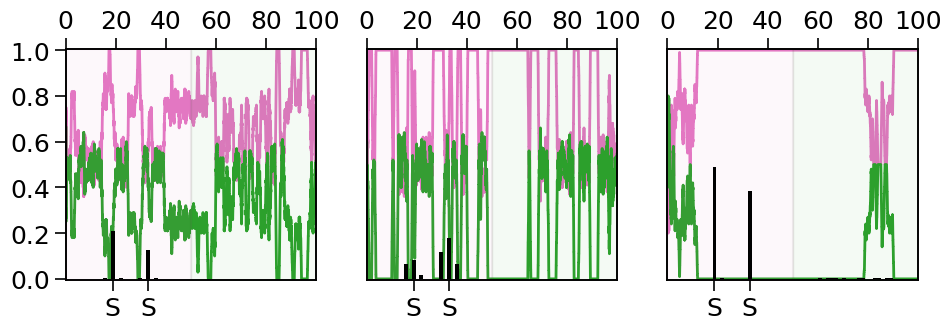

In [25]:
windowMax = 100
nPDBread = 10000
xlim = [0, nPDBread/100] # by default, timestep = 1 us, timewrite = 1e5,
histStart = 0
pfolder = f'../Simulations/NERDSS/'

plotTogether(
    PDBfolder1=pfolder+'/kpp7kpn3kps10_B_A/PDB/', pdbWriteStep1=1e5,
    PDBfolder2=pfolder+'/kpp20kpn3kps10_B_A/PDB/', pdbWriteStep2=1e5,
    PDBfolder3=pfolder+'/kpp7kpn7kps14_B_A/PDB/', pdbWriteStep3=1e5,
#     PDBfolder3=pfolder+'/kpp20kpn7kps14_B_A/PDB/', pdbWriteStep3=1e5,
    nStart = 2, windowMax = windowMax, histStart=histStart, 
    nPDBread=nPDBread, xlim = xlim,
    xticks = [12, 21], xtickLabels = ['S', 'S'],
    axlineWidth=1.2, curveWidth=2,
    figsize=(11,3), wspace=0.2,
)

9999 PDBs read.
9999 PDBs read.
9999 PDBs read.
0.9632963296329633
0.9386438643864384
0.9394439443944396


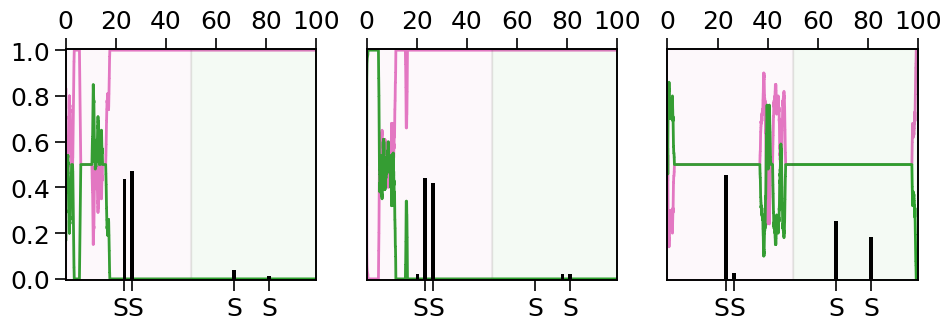

In [26]:
plotTogether(
    PDBfolder1=pfolder+'/kpp7kpn3kps10_C_B/PDB/', pdbWriteStep1=1e5,
    PDBfolder2=pfolder+'/kpp20kpn3kps10_C_B/PDB/', pdbWriteStep2=1e5,
    PDBfolder3=pfolder+'/kpp7kpn7kps14_C_B/PDB/', pdbWriteStep3=1e5,
#     PDBfolder3=pfolder+'/kpp20kpn7kps14_C_B//PDB/', pdbWriteStep3=1e5,
    nStart = 2, windowMax = windowMax, histStart=histStart, 
    nPDBread=nPDBread, xlim = xlim,
    xticks = [15, 17, 43, 52], xtickLabels = ['S ', ' S', 'S', 'S'],
    axlineWidth=1.2, curveWidth=2,
    figsize=(11,3), wspace=0.2,
)

9999 PDBs read.
9999 PDBs read.
9999 PDBs read.
0.9420442044204419
0.9652965296529652
0.9934993499349934


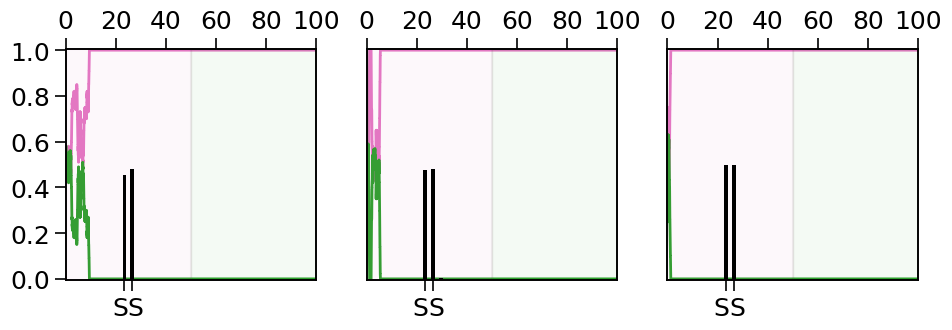

In [27]:
plotTogether(
    PDBfolder1=pfolder+'/kpp7kpn3kps10_C_A/PDB/', pdbWriteStep1=1e5,
    PDBfolder2=pfolder+'/kpp20kpn3kps10_C_A/PDB/', pdbWriteStep2=1e5,
    PDBfolder3=pfolder+'/kpp7kpn7kps14_C_A/PDB/', pdbWriteStep3=1e5,
#     PDBfolder3=pfolder+'/kpp20kpn7kps14_C_A//PDB/', pdbWriteStep3=1e5,
    nStart = 2, windowMax = windowMax, histStart=histStart, 
    nPDBread=nPDBread, xlim = xlim,
    xticks = [15, 17], xtickLabels = ['S ', ' S'],
    axlineWidth=1.2, curveWidth=2,
    figsize=(11,3), wspace=0.2,
)